In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

(32, 256, 256, 3)


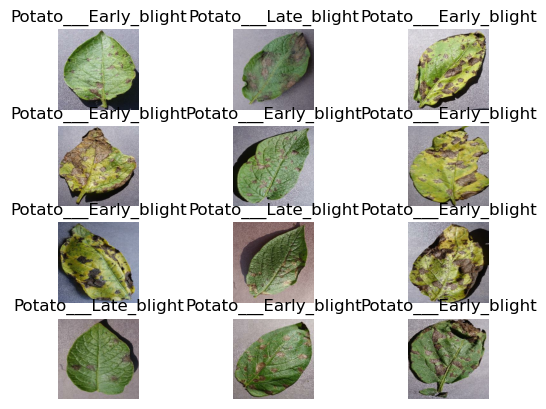

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    for i in range(12):
        ax = plt.subplot(4, 3, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    # print(image_batch[0].shape)
    # print(label_batch.numpy())

In [7]:
len(dataset)

68

In [8]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [9]:
train_size = 0.8
len(dataset)*train_size

# dataset.take(10)

54.400000000000006

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [12]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1,  test_split=0.1, shuffle = True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed =12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
    
                              
                              

In [16]:

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:

len(train_ds)

54

In [18]:
len(val_ds)

6

In [19]:

len(test_ds)

8

<-----------Cache, Shuffle, and Prefetch the Dataset------>

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

// Building the model

In [21]:
# Layer for resizing and normalization /256

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

Data Augmentation

In [22]:

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [23]:
# applying data augmentation to training dataset

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# model architecture
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 467s 7s/step - accuracy: 0.4792 - loss: 0.8972 - val_accuracy: 0.4271 - val_loss: 0.9691
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 323s 6s/step - accuracy: 0.6817 - loss: 0.6679 - val_accuracy: 0.7292 - val_loss: 0.6332
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 319s 6s/step - accuracy: 0.7911 - loss: 0.4818 - val_accuracy: 0.8281 - val_loss: 0.4193
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 309s 6s/step - accuracy: 0.8409 - loss: 0.3730 - val_accuracy: 0.9167 - val_loss: 0.2763
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 419s 8s/step - accuracy: 0.8987 - loss: 0.2703 - val_accuracy: 0.8750 - val_loss: 0.2546
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 251s 4s/step - accuracy: 0.8883 - loss: 0.2587 - val_accuracy: 0.8802 - val_loss: 0.2416
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 312s 6s/step - accuracy: 0.9207 - loss: 0.2194 - val_accuracy: 0.9271 - val_loss: 0.1536
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 274s 5s/step - accuracy: 0.9427 - loss: 0.1706 - val_accuracy: 0.8802 - v

In [29]:

history

In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [31]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [32]:

type(history.history['loss'])

list

In [33]:

len(history.history['loss'])

50

In [34]:

history.history['loss'][:5] # show loss for first 5 epochs

[0.8972129225730896,
 0.6678858399391174,
 0.4817866086959839,
 0.41877439618110657,
 0.37304574251174927]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

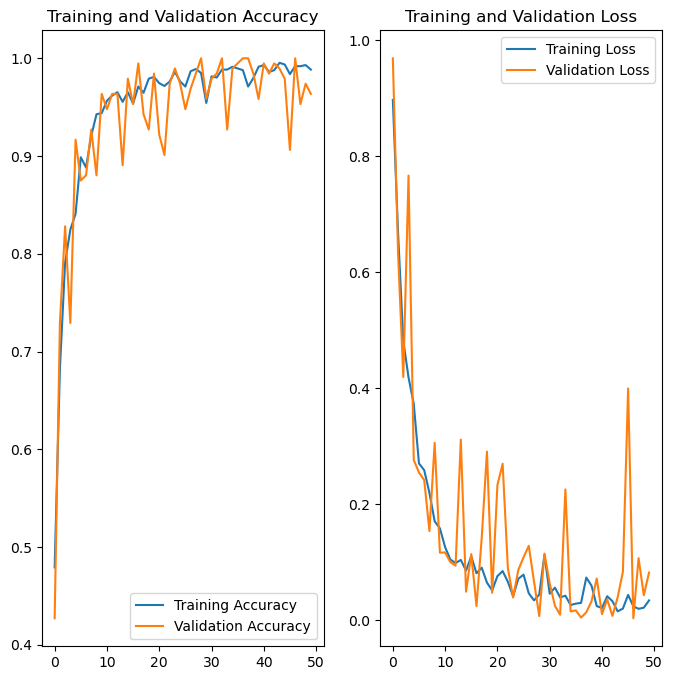

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
predicted label: Potato___Early_blight


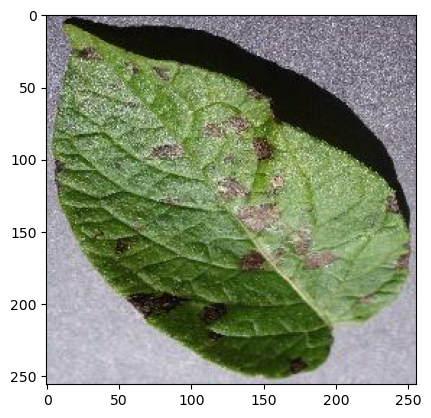

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [38]:
# function for inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


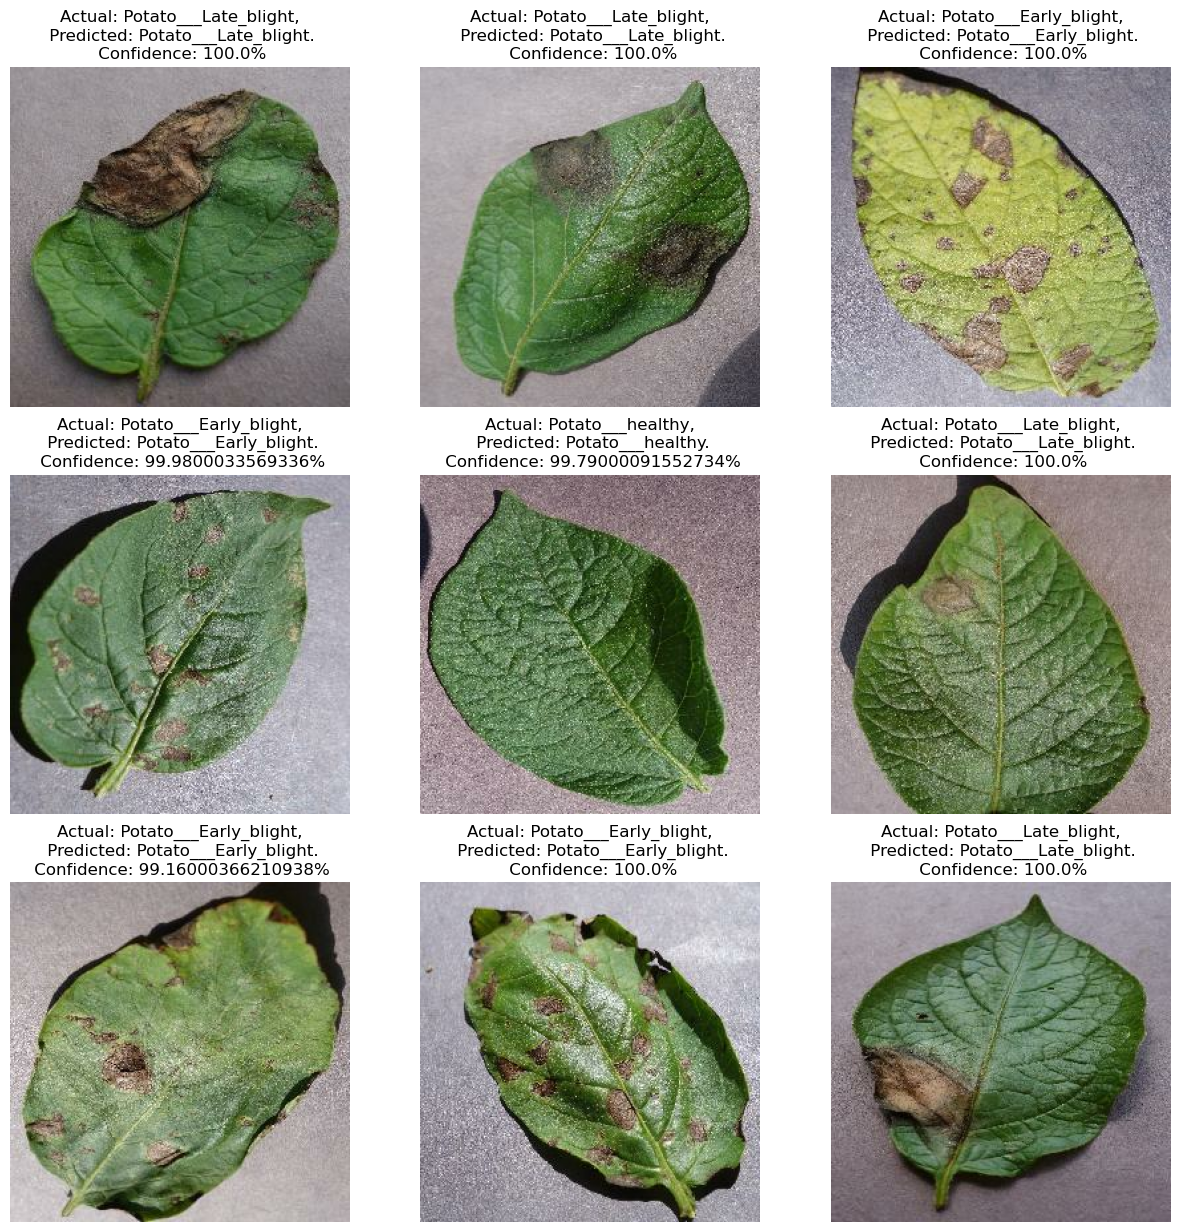

In [39]:
# run inference on few sample images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [44]:
import os
model_dir = "../models"
os.makedirs(model_dir, exist_ok=True)
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"{model_dir}/{model_version}.keras")

In [46]:

model.save("../potatoes.keras")

In [ ]:

> Blockquote